### Visualización


Información del estudio:
Frecuencia de muestreo: 500 Hz
Número de señales: 12
Duración: 10.00 segundos
Canales disponibles: ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


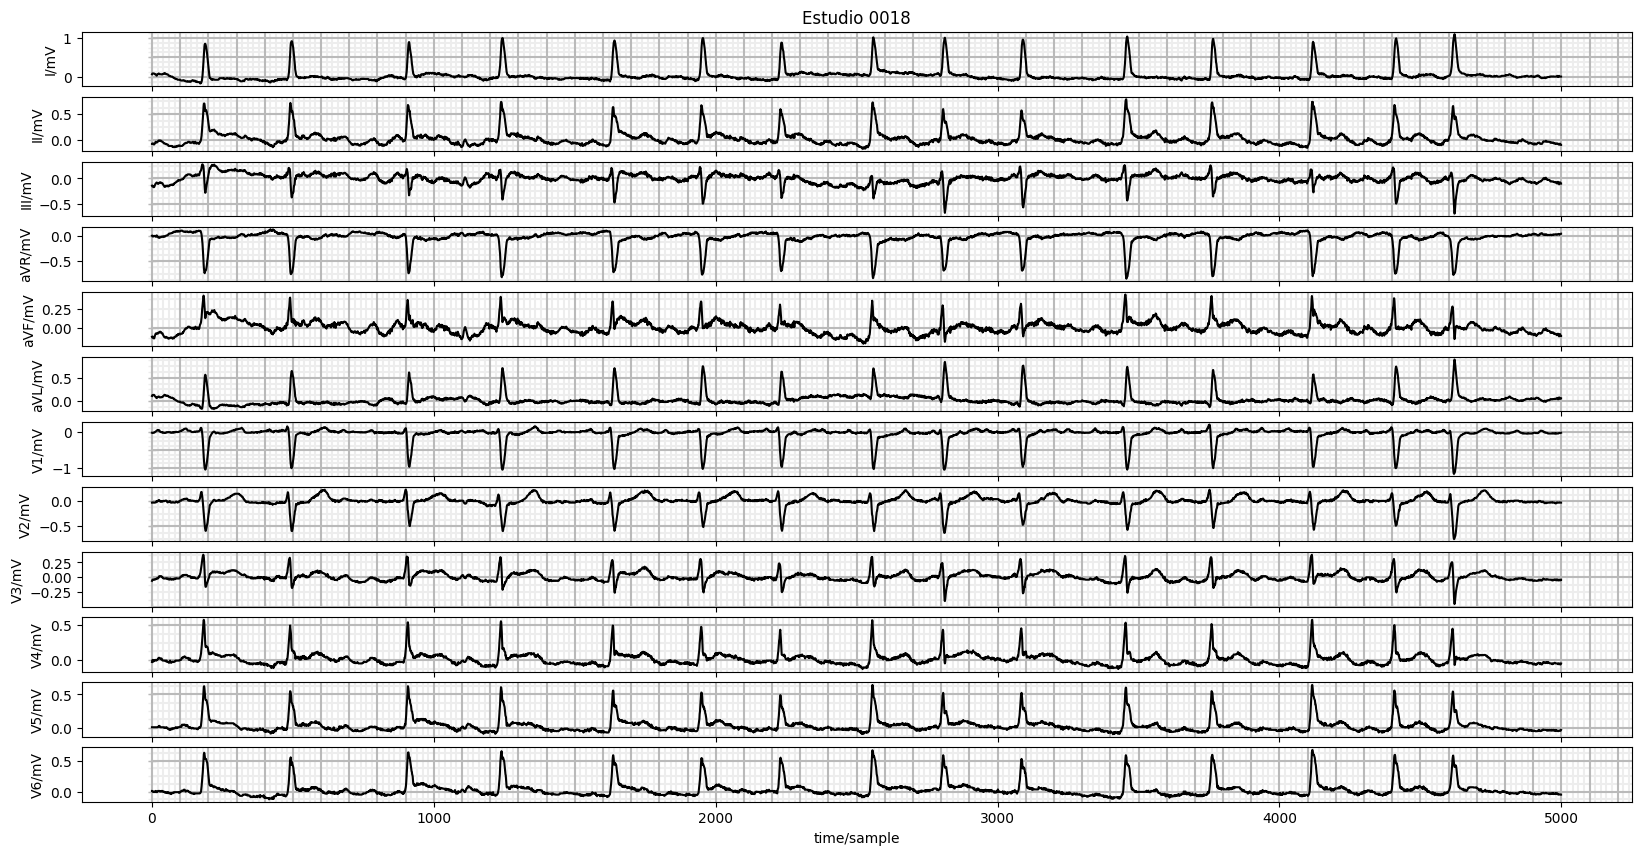

In [1]:
import wfdb
import os
import numpy as np

# Rutas
#base = "C:/Users/willi/OneDrive - PUJ Cali/Tesis/Base de datos MyoAlert Vision/ECG_NORMAL"
base= "C:/Users/willi/OneDrive - PUJ Cali/Tesis/Base de datos MyoAlert Vision/ECG_IAMCEST"

ecg_id = "s0018"
mode = "complete"

def data_loading(ecg_id, mode):
    
    """
    Visualiza el ECG del paciente en la carpeta ecg_id dentro de base,
    con modo 'complete' o canales específicos separados por coma por ejemplo (I,II,V1,V3).
    """
    paciente_path = os.path.join(base, ecg_id)

    if not os.path.exists(paciente_path):
        print(f"No se encontró la carpeta para el paciente: {ecg_id}")
        return

    archivos = os.listdir(paciente_path)

    # Buscar el .hea
    archive_hea = None
    for archivo in archivos:
        if archivo.endswith('.hea'):
            archive_hea = archivo
            break

    if archive_hea is None:
        print(f"Archivo .hea no encontrado en: {paciente_path}")
        return

    nombre_base = archive_hea.split(".")[0]
    rec_path = os.path.join(paciente_path, nombre_base)

    rd_record = wfdb.rdrecord(rec_path)

    # Información básica
    print(f"\nInformación del estudio:")
    print(f"Frecuencia de muestreo: {rd_record.fs} Hz")
    print(f"Número de señales: {rd_record.n_sig}")
    print(f"Duración: {rd_record.sig_len / rd_record.fs:.2f} segundos")
    print(f"Canales disponibles: {rd_record.sig_name}")

    if mode == "complete":
        sig_style = ['k'] * rd_record.n_sig
        wfdb.plot_wfdb(
            record=rd_record,
            figsize=(20, 10),
            title=f'Estudio {nombre_base}',
            ecg_grids='all',
            sig_style=sig_style
        )
    else:
        canales_solicitados = [c.strip() for c in mode.split(',')]
        indices_canales = []
        for i, name in enumerate(rd_record.sig_name):
            if name in canales_solicitados:
                indices_canales.append(i)

        if not indices_canales:
            print(f"No se encontraron los canales solicitados: {mode}")
            return

        # Construir objeto sólo con los canales deseados
        señales = np.array([rd_record.p_signal[:, i] for i in indices_canales]).T

        plot_record = wfdb.Record(
            p_signal=señales,
            fs=rd_record.fs,
            sig_name=[rd_record.sig_name[i] for i in indices_canales],
            n_sig=len(indices_canales)
        )

        plot_record.units = ['mV'] * plot_record.n_sig
        sig_style = ['k'] * plot_record.n_sig

        wfdb.plot_wfdb(
            record=plot_record,
            figsize=(30, 10),
            title=f'Estudio {nombre_base} (Canales: {mode})',
            ecg_grids='all',
            sig_style=sig_style
        )

# Llamar a la función
data_loading(ecg_id, mode)


### Preprocesamiento

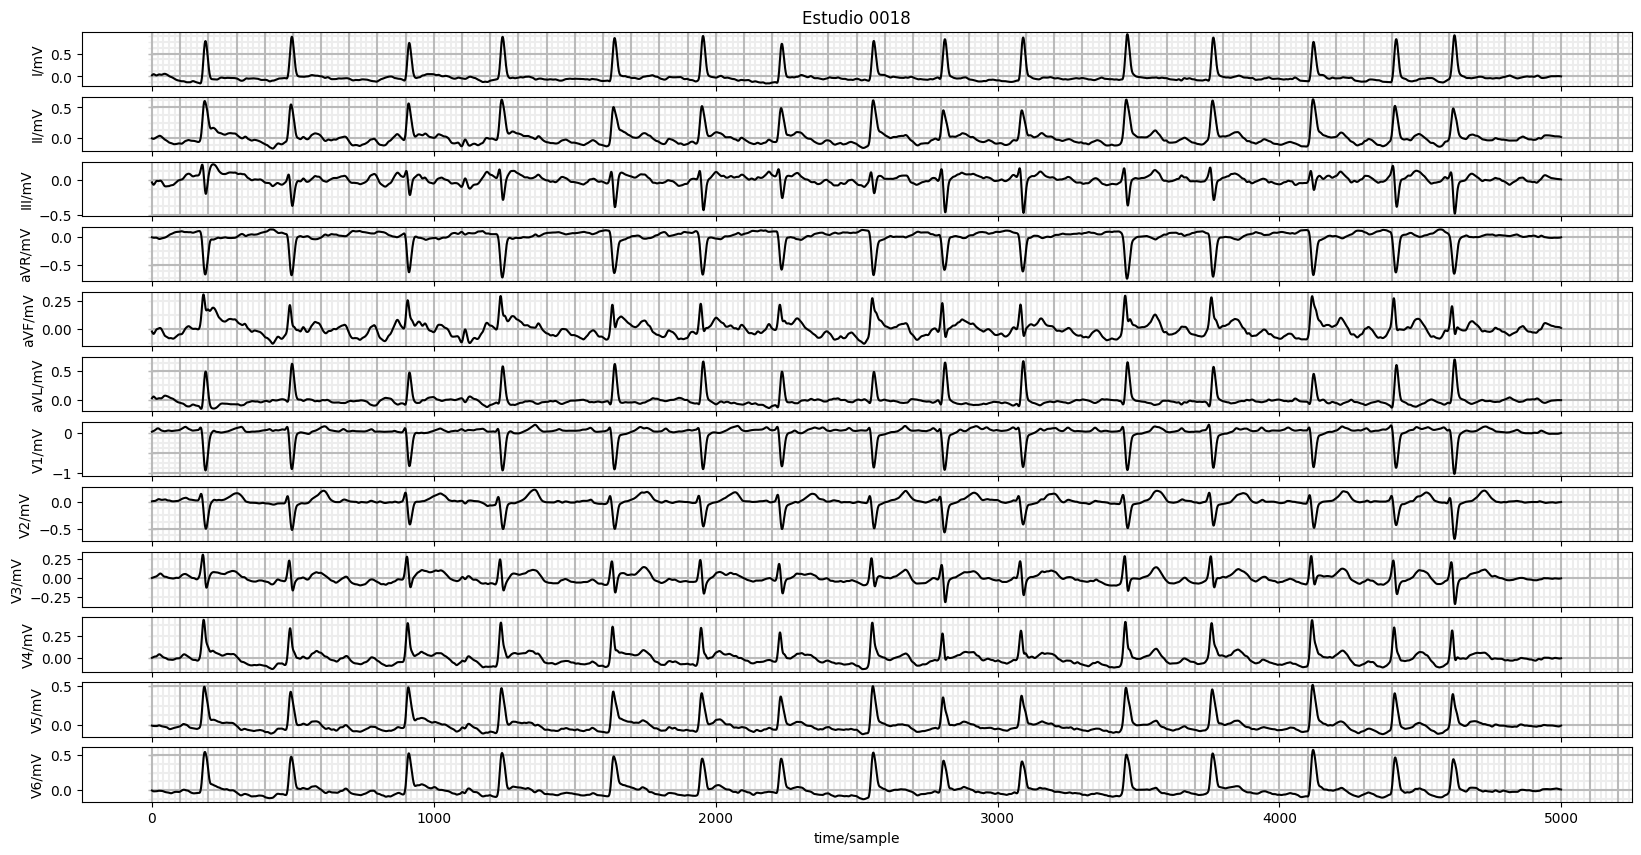

In [ ]:
import numpy as np
import os
import wfdb
from scipy.signal import butter, filtfilt, convolve
from scipy.signal.windows import hann

# FILTRADO
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist / Evitar el aliasing
    
    # Normalización
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Coeficientes del filtro
    return b, a

def apply_filter(data, lowcut, highcut, fs):

    # Filtro paso banda Butterworth
    b, a = butter_bandpass(lowcut, highcut, fs) 
    bandpass_filtered = filtfilt(b, a, data)
    
    # Aplicación de kernel Hanning para suavizado
    window_size = int(fs / 30) 
    if window_size % 2 == 0:
        window_size += 1 
    hanning_kernel = hann(window_size) / np.sum(hann(window_size))
    smoothed_signal = convolve(bandpass_filtered, hanning_kernel, mode='same')
    
    return smoothed_signal

def preprocessing(ecg_id, mode, lowcut=0.5, highcut=40, fs=500,plot=True):
    global filtered_signals_global, signal_names_global
    
    paciente_path = os.path.join(base, ecg_id)
    if not os.path.exists(paciente_path):
        print(f"No se encontró la carpeta para el paciente: {ecg_id}")
        return

    archive_exam = os.listdir(paciente_path)
    archive_hea = None
    
    for archivo in archive_exam:
        if archivo.endswith('.hea'):
            archive_hea = archivo
            break

    if archive_hea:
        rec_path = os.path.join(paciente_path, archive_hea.split(".")[0])
        #print(f"Leyendo archivo {rec_path}")
        
        rd_record = wfdb.rdrecord(rec_path)

        if mode == "complete":
            filtered_signals = []
            for i in range(rd_record.p_signal.shape[1]):
                signal = rd_record.p_signal[:, i]
                filtered = apply_filter(signal, lowcut, highcut, fs)
                filtered_signals.append(filtered)

            filtered_signals = np.array(filtered_signals).T
            filtered_signals_global = filtered_signals
            signal_names_global = rd_record.sig_name

            filtered_record = wfdb.Record(
                p_signal=filtered_signals,
                fs=rd_record.fs,
                sig_name=rd_record.sig_name,
                n_sig=rd_record.n_sig
            )

            filtered_record.units = ['mV'] * rd_record.n_sig
            sig_style = ['k'] * filtered_record.n_sig
            if plot:
                wfdb.plot_wfdb(
                    record=filtered_record,
                    figsize=(20, 10),
                    title=f'Estudio {archive_hea.split(".")[0]}',
                    ecg_grids='all',
                    sig_style=sig_style
                )
                
        else:
            channels = mode.split(',')
            
            # Obtiene la derivación solicitada
            for i in range(len(channels)):
                channels[i] = channels[i].strip()  # Recorrer la lista y eliminar espacios vacíos
      
            names = rd_record.sig_name  # Lista de nombres de las señales en el archivo
            plot_ecg = []
            
            for i, name in enumerate(names):
 
                if name in channels:
      
                    plot_ecg.append(i)

            if not plot_ecg:  
                print(f"No se encontró la derivación {mode}.")
                return 

            # Crear una lista con las señales filtradas para los canales seleccionados
            filtered_signals = []

            # Recorrer los canales seleccionados y aplicar el filtro
            for ecg_channel in plot_ecg:
                filtered_signal = apply_filter(rd_record.p_signal[50:, ecg_channel], lowcut, highcut, fs)
                filtered_signals.append(filtered_signal)


            # Guardar las señales filtradas en la variable
            filtered_signals_global = np.array(filtered_signals)  
            signal_names_global = [names[i] for i in plot_ecg]  # Guardar nombres de derivaciones

            filtered_record = wfdb.Record(
                p_signal=filtered_signals_global.T, 
                fs=rd_record.fs,
                sig_name=[names[i] for i in plot_ecg],  
                n_sig=len(plot_ecg)
            )

            # Establecer las unidades de las señales
            filtered_record.units = ['mV'] * filtered_record.n_sig  

            sig_style = ['k'] * filtered_record.n_sig 
            
            # Graficar las señales filtradas
            wfdb.plot_wfdb(record=filtered_record, figsize=(30, 10), 
                        title=f'Filtrado del estudio {archive_hea.split(".")[0]}', 
                        ecg_grids='all', sig_style=sig_style)

    else:
        print(f"Archivo .hea faltante en el examen: {ecg_id}")


# Llamar a la función
preprocessing(ecg_id,mode)


### Extracción de características

In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.signal import welch, hilbert
from scipy.stats import kurtosis
import EntropyHub as EH
import pywt

# Pacientes
ECG_NORM = [f"s{str(i).zfill(4)}" for i in range(1, 8869)]
ECG_IAM = [f"s{str(i).zfill(4)}" for i in range(1, 8869)]

#  Rutas
base_norm = "C:/Users/willi/OneDrive - PUJ Cali/Tesis/Base de datos MyoAlert Vision/ECG_NORMAL"
base_iam = "C:/Users/willi/OneDrive - PUJ Cali/Tesis/Base de datos MyoAlert Vision/ECG_IAMCEST"


# Funciones de ayuda

def get_psd(sig, fs=500, nperseg=512):
    f, p = welch(sig, fs=fs, nperseg=nperseg)
    return f, p

def reconstruct_phase_space(sig, m=2, tau=1):
    N = len(sig) - (m - 1) * tau
    if N <= 0:
        return np.empty((0, m))
    return np.array([sig[i:i + m * tau:tau] for i in range(N)])

def safe_matrix_rank(X):
    if X.size == 0 or np.isnan(X).any() or np.isinf(X).any():
        return 0
    try:
        return np.linalg.matrix_rank(X)
    except np.linalg.LinAlgError:
        return 0

def frequency_calculation(sig, fs=500):
    freqs = np.fft.rfftfreq(len(sig), 1/fs)
    fft_vals = np.abs(np.fft.rfft(sig))**2
    return freqs[np.argmax(fft_vals)]

def complexity_measure(sig):
    diffs = np.diff(sig)
    return np.sum(np.abs(diffs)) / len(sig)

def energy(sig):
    return np.sum(sig**2)

def renyi_entropy(sig, alpha=2, bins=100):
    sig = np.asarray(sig)
    sig = sig[np.isfinite(sig)]
    if sig.size == 0:
        return np.nan
    counts, _ = np.histogram(sig, bins=bins)
    p = counts.astype(float) / counts.sum()
    p = p[p > 0]
    if p.size == 0:
        return np.nan
    return (1.0 / (1.0 - alpha)) * np.log2(np.sum(p**alpha))

def wavelet_entropy(sig, wavelet='db4', level=4):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    energies = np.array([np.sum(c**2) for c in coeffs])
    ps = energies / np.sum(energies)
    return -np.sum(ps * np.log2(ps + 1e-12))

# Caracteristicas

caracteristicas_temporales = {
    "MAva": lambda sig: np.mean(np.abs(sig)),
    "bCP": lambda sig: np.count_nonzero(np.diff((np.abs(sig) < 0.1).astype(int))),
    "TCSC": lambda sig: np.sum(np.diff(np.sign(sig - 0.1)) != 0) + np.sum(np.diff(np.sign(sig + 0.1)) != 0),
    "TCin": lambda sig: (np.mean(np.diff(np.where(np.diff(np.sign(sig - 0.1)) != 0)[0]))
                        if len(np.where(np.diff(np.sign(sig - 0.1)) != 0)[0]) > 1 else 0),
    "SEal": lambda sig: np.mean(np.exp(-np.abs(sig))),
    "MEal": lambda sig: np.mean(np.exp(-np.square(sig))),
    "Count1": lambda sig: np.sum((sig >= -0.1) & (sig <= 0.1)),
    "Count2": lambda sig: np.sum((sig >= -0.2) & (sig <= 0.2)),
    "Count3": lambda sig: np.sum((sig >= -0.3) & (sig <= 0.3)),
}

caracteristicas_espectrales = {
    "CFre": lambda f, p: np.sum(f * p) / np.sum(p),
    "A1": lambda f, p: np.trapz(p[(f >= 0) & (f <= 125)], f[(f >= 0) & (f <= 125)]),
    "A2": lambda f, p: np.trapz(p[(f > 125) & (f <= 250)], f[(f > 125) & (f <= 250)]),
    "PSan": lambda f, p: np.mean(p),
    "CPow": lambda f, p: p[np.abs(f - (np.sum(f * p) / np.sum(p))).argmin()],
    "Y_Li": lambda f, p: (np.sum(p[(f >= 0.5) & (f <= 40)]) / np.sum(p)) if np.sum(p) > 0 else 0,
    "bW": lambda f, p: np.sqrt(np.sum(((f - (np.sum(f * p)/np.sum(p)))**2) * (p/np.sum(p)))),
    "VFLM": lambda f, p: (np.sum(p[(f >= 4) & (f <= 8)]) / np.sum(p)) if np.sum(p) > 0 else 0,
}

caracteristicas_complejas = {
    "HTra": lambda sig: np.mean(np.abs(hilbert(sig))),
    "CCal": lambda sig: np.var(sig),
    "ACal": lambda sig: np.trapz(np.abs(sig)),
    "FCal": lambda sig: frequency_calculation(sig, fs=500),
    "Kurt": lambda sig: kurtosis(sig),
    "CMea": lambda sig: complexity_measure(sig),
    "DEnt": lambda sig: EH.DispEn(sig, m=3, c=6, tau=1)[0],
    "Ener": lambda sig: energy(sig),
    "REnt": lambda sig: renyi_entropy(sig),
    "WEnt": lambda sig: wavelet_entropy(sig),
    "bWT": lambda sig: sum(np.sum(c**2) for c in pywt.wavedec(sig, 'db4', level=4))
}


# Procesamiento de pacientes

def procesar_pacientes(pacientes, base, resultados):
    for paciente in pacientes:
        ruta_archivo = os.path.join(base, paciente)
        preprocessing(ruta_archivo, mode="complete", plot=False)

        resultados[paciente] = {}
        for i, deriv in enumerate(signal_names_global):
            sig = filtered_signals_global[:, i]
            f, p = get_psd(sig)

            resultados[paciente][deriv] = {
                **{nombre: ftemp(sig) for nombre, ftemp in caracteristicas_temporales.items()},
                **{nombre: fesp(f, p) for nombre, fesp in caracteristicas_espectrales.items()},
                **{nombre: fcomp(sig) for nombre, fcomp in caracteristicas_complejas.items()}
            }


# Ejecutar pipeline

resultados_norm = {}
resultados_iam = {}

procesar_pacientes(ECG_NORM, base_norm, resultados_norm)
procesar_pacientes(ECG_IAM, base_iam, resultados_iam)

# Convertir a DataFrames
df_norm = pd.DataFrame([
    {"Paciente": p, "Derivación": d, **vals}
    for p, derivs in resultados_norm.items()
    for d, vals in derivs.items()
])
df_norm["Clase"] = 0

df_iam = pd.DataFrame([
    {"Paciente": p, "Derivación": d, **vals}
    for p, derivs in resultados_iam.items()
    for d, vals in derivs.items()
])
df_iam["Clase"] = 1

df_all = pd.concat([df_norm, df_iam], ignore_index=True)

# Pivot
df_pivot = df_all.pivot_table(
    index=["Paciente", "Clase"],
    columns="Derivación",
    values=[c for c in df_all.columns if c not in ["Paciente", "Clase", "Derivación"]]
)
df_pivot.columns = [f"{der}_{car}" for car, der in df_pivot.columns]
df_final = df_pivot.reset_index()

# Ordenar columnas
derivaciones = ["I","II","III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"]
features = sorted(list({col.split("_", 1)[1] for col in df_final.columns if "_" in col}))
col_order = ["Paciente", "Clase"] + [f"{d}_{f}" for d in derivaciones for f in features]

df_final = df_final[col_order]

# Mostrar primeras filas
pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", None)
display(df_final)

# Guardar
df_final.to_csv("ecg_pacientes.csv", index=False, sep=";", decimal=",")


,Paciente,Clase,I_A1,I_A2,I_ACal,I_CCal,I_CFre,I_CMea,I_CPow,I_Count1,I_Count2,I_Count3,I_DEnt,I_Ener,I_FCal,I_HTra,I_Kurt,I_MAva,I_MEal,I_PSan,I_REnt,I_SEal,I_TCSC,I_TCin,I_VFLM,I_WEnt,I_Y_Li,I_bCP,I_bW,I_bWT,II_A1,II_A2,II_ACal,II_CCal,II_CFre,II_CMea,II_CPow,II_Count1,II_Count2,II_Count3,II_DEnt,II_Ener,II_FCal,II_HTra,II_Kurt,II_MAva,II_MEal,II_PSan,II_REnt,II_SEal,II_TCSC,II_TCin,II_VFLM,II_WEnt,II_Y_Li,II_bCP,II_bW,II_bWT,III_A1,III_A2,III_ACal,III_CCal,III_CFre,III_CMea,III_CPow,III_Count1,III_Count2,III_Count3,III_DEnt,III_Ener,III_FCal,III_HTra,III_Kurt,III_MAva,III_MEal,III_PSan,III_REnt,III_SEal,III_TCSC,III_TCin,III_VFLM,III_WEnt,III_Y_Li,III_bCP,III_bW,III_bWT,aVR_A1,aVR_A2,aVR_ACal,aVR_CCal,aVR_CFre,aVR_CMea,aVR_CPow,aVR_Count1,aVR_Count2,aVR_Count3,aVR_DEnt,aVR_Ener,aVR_FCal,aVR_HTra,aVR_Kurt,aVR_MAva,aVR_MEal,aVR_PSan,aVR_REnt,aVR_SEal,aVR_TCSC,aVR_TCin,aVR_VFLM,aVR_WEnt,aVR_Y_Li,aVR_bCP,aVR_bW,aVR_bWT,aVL_A1,aVL_A2,aVL_ACal,aVL_CCal,aVL_CFre,aVL_CMea,aVL_CPow,aVL_Count1,aVL_Count2,aVL_Count3,aVL_DEnt,aVL_Ener,aVL_FCal,aVL_HTra,aVL_Kurt,aVL_MAva,aVL_MEal,aVL_PSan,aVL_REnt,aVL_SEal,aVL_TCSC,aVL_TCin,aVL_VFLM,aVL_WEnt,aVL_Y_Li,aVL_bCP,aVL_bW,aVL_bWT,aVF_A1,aVF_A2,aVF_ACal,aVF_CCal,aVF_CFre,aVF_CMea,aVF_CPow,aVF_Count1,aVF_Count2,aVF_Count3,aVF_DEnt,aVF_Ener,aVF_FCal,aVF_HTra,aVF_Kurt,aVF_MAva,aVF_MEal,aVF_PSan,aVF_REnt,aVF_SEal,aVF_TCSC,aVF_TCin,aVF_VFLM,aVF_WEnt,aVF_Y_Li,aVF_bCP,aVF_bW,aVF_bWT,V1_A1,V1_A2,V1_ACal,V1_CCal,V1_CFre,V1_CMea,V1_CPow,V1_Count1,V1_Count2,V1_Count3,V1_DEnt,V1_Ener,V1_FCal,V1_HTra,V1_Kurt,V1_MAva,V1_MEal,V1_PSan,V1_REnt,V1_SEal,V1_TCSC,V1_TCin,V1_VFLM,V1_WEnt,V1_Y_Li,V1_bCP,V1_bW,V1_bWT,V2_A1,V2_A2,V2_ACal,V2_CCal,V2_CFre,V2_CMea,V2_CPow,V2_Count1,V2_Count2,V2_Count3,V2_DEnt,V2_Ener,V2_FCal,V2_HTra,V2_Kurt,V2_MAva,V2_MEal,V2_PSan,V2_REnt,V2_SEal,V2_TCSC,V2_TCin,V2_VFLM,V2_WEnt,V2_Y_Li,V2_bCP,V2_bW,V2_bWT,V3_A1,V3_A2,V3_ACal,V3_CCal,V3_CFre,V3_CMea,V3_CPow,V3_Count1,V3_Count2,V3_Count3,V3_DEnt,V3_Ener,V3_FCal,V3_HTra,V3_Kurt,V3_MAva,V3_MEal,V3_PSan,V3_REnt,V3_SEal,V3_TCSC,V3_TCin,V3_VFLM,V3_WEnt,V3_Y_Li,V3_bCP,V3_bW,V3_bWT,V4_A1,V4_A2,V4_ACal,V4_CCal,V4_CFre,V4_CMea,V4_CPow,V4_Count1,V4_Count2,V4_Count3,V4_DEnt,V4_Ener,V4_FCal,V4_HTra,V4_Kurt,V4_MAva,V4_MEal,V4_PSan,V4_REnt,V4_SEal,V4_TCSC,V4_TCin,V4_VFLM,V4_WEnt,V4_Y_Li,V4_bCP,V4_bW,V4_bWT,V5_A1,V5_A2,V5_ACal,V5_CCal,V5_CFre,V5_CMea,V5_CPow,V5_Count1,V5_Count2,V5_Count3,V5_DEnt,V5_Ener,V5_FCal,V5_HTra,V5_Kurt,V5_MAva,V5_MEal,V5_PSan,V5_REnt,V5_SEal,V5_TCSC,V5_TCin,V5_VFLM,V5_WEnt,V5_Y_Li,V5_bCP,V5_bW,V5_bWT,V6_A1,V6_A2,V6_ACal,V6_CCal,V6_CFre,V6_CMea,V6_CPow,V6_Count1,V6_Count2,V6_Count3,V6_DEnt,V6_Ener,V6_FCal,V6_HTra,V6_Kurt,V6_MAva,V6_MEal,V6_PSan,V6_REnt,V6_SEal,V6_TCSC,V6_TCin,V6_VFLM,V6_WEnt,V6_Y_Li,V6_bCP,V6_bW,V6_bWT
0,s0001,0,0.010,1.595e-15,305.943,0.009,7.662,0.004,8.124e-04,4389.0,4751.0,4896.0,1.819,46.693,3.1,0.098,11.108,0.061,0.991,3.996e-05,3.849,0.943,58.0,116.103,0.258,0.647,0.980,58.0,6.236,46.699,0.007,1.480e-15,254.506,0.006,8.218,0.004,6.892e-04,4532.0,4876.0,4912.0,2.049,30.911,3.1,0.081,11.024,0.051,0.994,2.660e-05,4.447,0.952,54.0,92.510,0.292,0.658,0.997,54.0,5.916,30.921,0.002,2.057e-16,151.308,0.002,5.349,0.002,1.295e-04,4793.0,5000.0,5000.0,2.303,8.544,1.0,0.045,1.890,0.030,0.998,7.355e-06,5.182,0.971,38.0,295.769,0.134,0.438,0.926,38.0,6.054,8.545,0.008,1.462e-15,269.569,0.007,8.074,0.004,7.216e-04,4503.0,4871.0,4903.0,1.791,36.084,3.1,0.087,12.013,0.054,0.993,3.095e-05,4.152,0.949,40.0,0.000,0.280,0.667,0.991,40.0,6.106,36.091,4.129e-03,5.112e-16,202.122,3.924e-03,6.963,0.003,2.151e-04,4567.0,4907.0,4960.0,1.857,19.619,4.1,0.064,8.764,0.040,0.996,1.678e-05,3.899,0.961,50.0,125.229,0.217,0.606,0.962,50.0,6.393,19.619,0.002,4.388e-16,137.513,0.002,7.514,0.002,1.719e-04,4880.0,4988.0,5000.0,2.316,7.931,2.1,0.042,5.851,0.028,0.998,6.885e-06,4.772,0.973,22.0,208.714,0.254,0.580,0.983,22.0,5.854,7.934,0.005,1.187e-15,192.077,0.005,8.419,0.003,3.557e-04,4778.0,4855.0,4903.0,1.822,25.049,3.1,0.062,18.108,0.038,0.9

### Modelo XGBoost para detección de infarto

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Cargar el dataset final
df = pd.read_csv("ecg_pacientes.csv", sep=";", decimal=",")

# Separar características y etiqueta
X = df.drop(columns=['Paciente', 'Clase'])
y = df['Clase']  # 0 = Normal, 1 = IAMCEST

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear el modelo XGBoost
xgb_model = XGBClassifier(
    random_state=43,   
    max_depth=6,         # profundidad máxima de cada árbol
    learning_rate=0.1,   # tasa de aprendizaje
    n_estimators=500, 
    reg_lambda=0.9,    
    reg_alpha=0.6   
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = xgb_model.predict(X_test)


# Guardar el modelo
joblib.dump(xgb_model, "xgb_model.pkl")


['xgb_model.pkl']

              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93      1770
     IAMCEST       0.95      0.91      0.93      1731

    accuracy                           0.93      3501
   macro avg       0.93      0.93      0.93      3501
weighted avg       0.93      0.93      0.93      3501



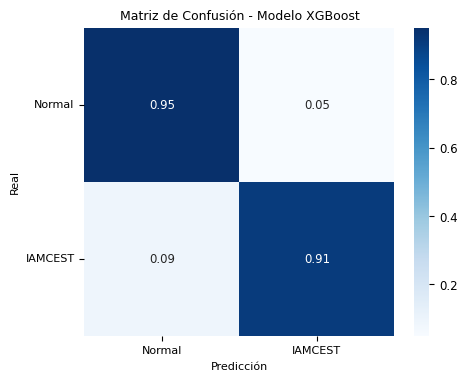

In [ ]:
# Evaluar
print(classification_report(y_test, y_pred, target_names=["Normal", "IAMCEST"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                 annot_kws={"size":8.5}) 

# Ajustar etiquetas
plt.xlabel('Predicción', fontsize=8)
plt.ylabel('Real', fontsize=8)
plt.title('Matriz de Confusión - Modelo XGBoost', fontsize=9)
plt.xticks([0.5, 1.5], ['Normal', 'IAMCEST'], fontsize=8)
plt.yticks([0.5, 1.5], ['Normal', 'IAMCEST'], fontsize=8, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8.5)

plt.show()

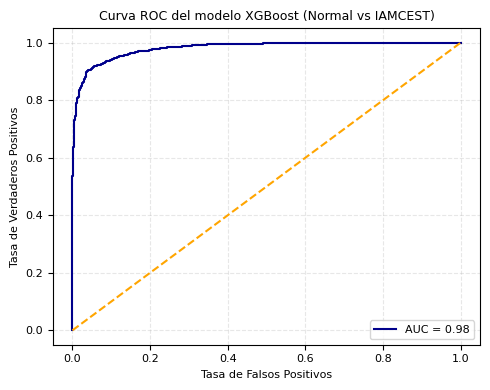

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular fpr, tpr y auc
y_prob = xgb_model.predict_proba(X_test)[:,1] 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='darkblue', lw=1.5,
         label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], color='orange', lw=1.5, linestyle='--')

plt.title('Curva ROC del modelo XGBoost (Normal vs IAMCEST)',fontsize=9)
plt.xlabel('Tasa de Falsos Positivos',fontsize=8)
plt.ylabel('Tasa de Verdaderos Positivos',fontsize=8)
plt.legend(loc="lower right",fontsize=8)
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### Determinación de la localización anatómica del IAMCEST - XGBoost + Valores SHAP

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import shap

# Cargar dataset
df = pd.read_csv("ecg_pacientes.csv", sep=";", decimal=",")

# Usar todos los pacientes
df_sample = df.reset_index(drop=True)

# X e y
X = df_sample.drop(columns=['Paciente', 'Clase']).astype(float)
y = df_sample['Clase'].astype(int)

feat_names = list(X.columns)

# Entrenar modelo XGBoost 
model = XGBClassifier(
    random_state=43,   
    max_depth=6,         # profundidad máxima de cada árbol
    learning_rate=0.05,   # tasa de aprendizaje
    n_estimators=1200, 
    reg_lambda=1.0,   # L2 
    reg_alpha=0.5  ,   
    eval_metric='logloss',  
)
model.fit(X, y)

# Calcular valores SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)
abs_shap = np.abs(shap_values.values)

# Definir grupos y reglas de contigüidad
groups = {
    'Septal': ['V1', 'V2'],
    'Anterior': ['V2', 'V3', 'V4'],
    'Lateral': ['I', 'aVL', 'V5', 'V6'],
    'Inferior': ['II', 'III', 'aVF']
}
contiguous_rules = {
    'Septal': [('V1', 'V2')],
    'Anterior': [('V2', 'V3'), ('V3', 'V4')],
    'Lateral': [('I', 'aVL'), ('V5', 'V6')],
    'Inferior': [('II', 'III'), ('III', 'aVF'), ('aVF', 'II')]
}

# Función get_der
def get_der(feat):
    return feat.split('_')[0]

# Sumar contribuciones por derivación 
der_matrix = []
for idx in range(len(df_sample)):
    contribs = abs_shap[idx]
    der_contribs = {}
    for feat, contrib in zip(feat_names, contribs):
        der = get_der(feat)
        der_contribs[der] = der_contribs.get(der, 0) + contrib
    der_matrix.append(der_contribs)

der_df = pd.DataFrame(der_matrix)
der_df['Clase'] = y.values
der_df['Paciente'] = df_sample['Paciente'].values

# Normalización inter-paciente (z-score por derivación usando solo normales)
normales = der_df[der_df['Clase'] == 0].drop(columns=['Clase', 'Paciente'])
means = normales.mean()
stds = normales.std().replace(0, 1e-6)

# z-score por derivación para todos los pacientes
z_scores = (der_df.drop(columns=['Clase', 'Paciente']) - means) / stds
z_scores['Clase'] = der_df['Clase']
z_scores['Paciente'] = der_df['Paciente']


#Umbrales estandar (original)
strong_thresh = 1.3
moderate_thresh = 1.0

#Umbrales flexibles
strong_relaxed = 1.0
moderate_relaxed = 0.8

results = []
count_contig_original = 0
count_contig_relaxed = 0
count_global = 0

for idx, row in z_scores.iterrows():
    patient_id = row['Paciente']
    clase = row['Clase']
    ders_z = row.drop(['Clase', 'Paciente'])

    # Primer filtro: umbrales originales
    strong_ders = {der for der, z in ders_z.items() if z > strong_thresh}
    moderate_ders = {der for der, z in ders_z.items() if z > moderate_thresh}

    most_affected_zone = []
    method_used = None
    relaxed_used = False

    if clase == 1:
        # función auxiliar para evaluar contigüidad con los sets strong/moderate
        def check_contiguity_with_sets(strong_set, moderate_set):
            zone_contribs_local = {}
            for zone, ders in groups.items():
                rules = contiguous_rules[zone]
                valid = False
                for d1, d2 in rules:
                    # Prioridad: dos fuertes contiguos
                    if d1 in strong_set and d2 in strong_set:
                        valid = True
                        break
                    # Fuerte + moderada
                    if (d1 in strong_set and d2 in moderate_set) or (d2 in strong_set and d1 in moderate_set):
                        valid = True
                        break
                if valid:
                    zone_contribs_local[zone] = sum(
                        der_df.loc[idx, der] if der in der_df.columns else 0 for der in ders
                    )
            return zone_contribs_local

        # probar con umbrales originales
        zone_contribs = check_contiguity_with_sets(strong_ders, moderate_ders)

        if not zone_contribs:
            # Segunda filtro intentar con umbrales relajados
            strong_ders_rel = {der for der, z in ders_z.items() if z > strong_relaxed}
            moderate_ders_rel = {der for der, z in ders_z.items() if z > moderate_relaxed}
            zone_contribs = check_contiguity_with_sets(strong_ders_rel, moderate_ders_rel)
            if zone_contribs:
                relaxed_used = True
                strong_ders = strong_ders_rel
                moderate_ders = moderate_ders_rel

        if zone_contribs:
            most_affected_zone = [max(zone_contribs, key=zone_contribs.get)]
            # contabilizar según si fue con original o relaxed
            if relaxed_used:
                count_contig_relaxed += 1
                method_used = "contiguidad_relaxed"
            else:
                count_contig_original += 1
                method_used = "contiguidad_original"
        else:
            # fallback: contribución global 
            global_zone_contribs = {
                zone: sum(der_df.loc[idx, der] if der in der_df.columns else 0 for der in ders)
                for zone, ders in groups.items()
            }
            most_affected_zone = [max(global_zone_contribs, key=global_zone_contribs.get)]
            count_global += 1
            method_used = "global"

    results.append({
        'Patient': patient_id,
        'Clase': clase,
        'Strong_Leads': list(strong_ders),  
        'Moderate_Leads': list(moderate_ders), 
        'Most_Affected_Zone': most_affected_zone,
        'Method': method_used,
    })


# Resultados finales
result_df = pd.DataFrame(results)
#result_df[result_df['Clase'] == 1].to_csv('predicciones_zonas_infarto.csv', index=False)
n_iam = result_df[result_df['Clase'] == 1].shape[0]
print("Distribución de zonas detectadas en pacientes con IAMCEST:")
print(result_df[result_df['Clase'] == 1]['Most_Affected_Zone'].value_counts())
print("\nResumen del método de detección:")
print(f"Contigüidad (original): {count_contig_original} ({count_contig_original/n_iam*100:.1f}%)")
print(f"Contigüidad (flexible): {count_contig_relaxed} ({count_contig_relaxed/n_iam*100:.1f}%)")
print(f"Contribución global (fallback): {count_global} ({count_global/n_iam*100:.1f}%)")


Distribución de zonas detectadas en pacientes con IAMCEST:
Most_Affected_Zone
[Anterior]    3133
[Inferior]    2496
[Lateral]     2341
[Septal]       682
Name: count, dtype: int64

Resumen del método de detección:
Contigüidad (original): 6692 (77.3%)
Contigüidad (flexible): 551 (6.4%)
Contribución global (fallback): 1409 (16.3%)


### Cálculo global de importancia por derivación 

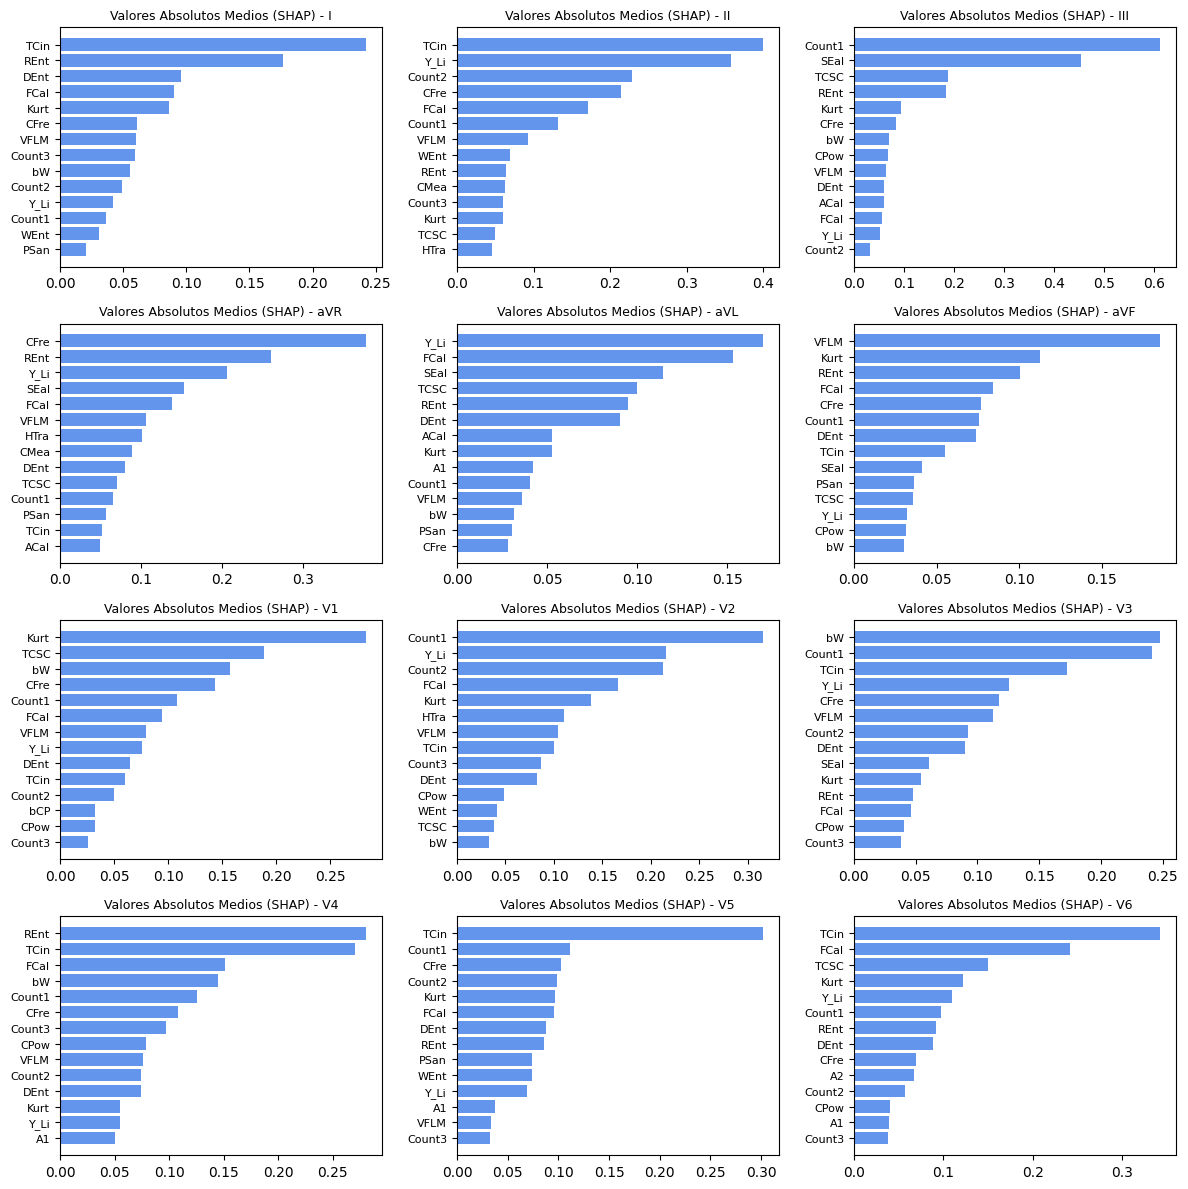

In [ ]:
import matplotlib.pyplot as plt

shap_importance = pd.DataFrame({
    "feature": feat_names,
    "mean_abs_shap": abs_shap.mean(axis=0)
})

# Extraer derivación y característica
shap_importance["derivacion"] = shap_importance["feature"].str.split("_").str[0]
shap_importance["caracteristica"] = shap_importance["feature"].str.split("_").str[1:]

shap_importance["caracteristica"] = shap_importance["caracteristica"].apply(lambda x: "_".join(x))

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

derivaciones = ["I", "II", "III", "aVR", "aVL", "aVF", 
                "V1", "V2", "V3", "V4", "V5", "V6"]

for i, der in enumerate(derivaciones):
    ax = axes[i]
    data = shap_importance[shap_importance["derivacion"] == der] \
               .sort_values("mean_abs_shap", ascending=False) \
               .head(14)
    
    ax.barh(data["caracteristica"], data["mean_abs_shap"], color="cornflowerblue")
    ax.set_title(f"Valores Absolutos Medios (SHAP) - {der}", fontsize=9)
    ax.invert_yaxis()
    ax.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()


### Modelo LighGBM para clasificación del infarto por localización

#### Técnica Gaussian Noise Up-Sampling (GNUS)

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# Función de aumentación con ruido
def augment_noise(df, scale=0.05):
    df_aug = df.copy()
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        col_std = df[col].std()
        df_aug[col] += np.random.normal(0, scale * col_std, size=len(df))
    return df_aug


# Cargar dataset
df = pd.read_csv("ecg_pacientes_predicciones_zonas_infarto.csv", sep=";", decimal=",")

# Filtrar clases relevantes
clases_relevantes = ["Anterior", "Inferior", "Lateral", "Septal"]
df_filtered = df[df["Clase"].isin(clases_relevantes)].reset_index(drop=True)

# Separar características y etiquetas
X = df_filtered.drop(columns=['Paciente', 'Clase'])
y = df_filtered['Clase']


# Plan de aumentación de datos por clase
augmentation_plan = {
    "Septal": 1,      # Se generan muestras sintéticas equivalentes al 100% de su tamaño original (duplicando la clase)
    "Lateral": 0.5,   # Se generan muestras sintéticas equivalentes al 50% de su tamaño original
    "Inferior": 0.5,  # Se generan muestras sintéticas equivalentes al 50% de su tamaño original
    "Anterior": 0     # No se aplica aumentación (la clase permanece sin cambios)
}

X_aug, y_aug = [], []
for target_class, n_aug in augmentation_plan.items():
    X_class = X[y == target_class]
    y_class = y[y == target_class]
    
    n_samples = int(len(X_class) * n_aug)
    if n_samples > 0:
        indices = np.random.choice(X_class.index, n_samples, replace=True)
        X_aug.append(augment_noise(X_class.loc[indices], scale=0.05))
        y_aug.append(y_class.loc[indices])

if X_aug:
    X = pd.concat([X] + X_aug, axis=0).reset_index(drop=True)
    y = pd.concat([y] + y_aug, axis=0).reset_index(drop=True)

print("Tamaño dataset después de augmentación:", X.shape, y.shape)
print("Distribución de clases:\n", y.value_counts())


# Validación cruzada estratificada (5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_per_class = {cls: {"precision": [], "recall": [], "f1": []} for cls in clases_relevantes}
accuracies = []
conf_matrices = []

best_score = -np.inf
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Modelo LightGBM
    lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=255,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.7,
        max_bin=255,
        class_weight="balanced",
        random_state=43,
        reg_alpha=1.0,
        reg_lambda=1.0,
        verbose=-1
    )

    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)

    # Accuracy global
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    # f1_macro como métrica de referencia
    f1_macro = f1_score(y_val, y_pred, average="macro")

    # Guardar el mejor modelo
    if f1_macro > best_score:
        best_score = f1_macro
        best_model = lgb_model

    # Métricas por clase
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred, labels=clases_relevantes, zero_division=0
    )
    for i, cls in enumerate(clases_relevantes):
        metrics_per_class[cls]["precision"].append(precision[i])
        metrics_per_class[cls]["recall"].append(recall[i])
        metrics_per_class[cls]["f1"].append(f1[i])

    # Matriz de confusión normalizada
    cm = confusion_matrix(y_val, y_pred, labels=clases_relevantes, normalize="true")
    conf_matrices.append(cm)

# Guardar el mejor modelo
joblib.dump(best_model, "lgb_model.pkl")

Tamaño dataset después de augmentación: (11752, 336) (11752,)
Distribución de clases:
 Clase
Inferior    3744
Lateral     3511
Anterior    3133
Septal      1364
Name: count, dtype: int64


['lgb_model.pkl']

Promedio métricas de validación


,Clase,Precision,Recall,F1-score
0,Anterior,0.84 ± 0.014,0.81 ± 0.009,0.82 ± 0.006
1,Inferior,0.89 ± 0.014,0.90 ± 0.018,0.89 ± 0.013
2,Lateral,0.86 ± 0.014,0.88 ± 0.020,0.87 ± 0.012
3,Septal,0.86 ± 0.023,0.86 ± 0.011,0.86 ± 0.010


Accuracy global: 0.86 ± 0.009


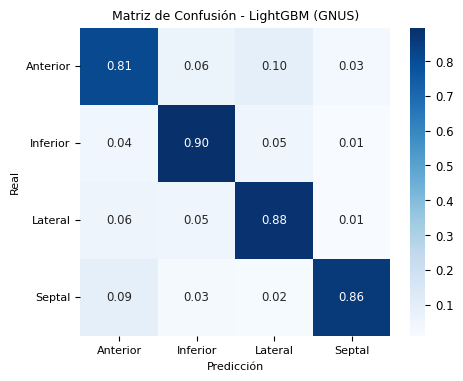

In [69]:
# Promedio métricas de validación
rows = []
for cls in clases_relevantes:
    p_mean, p_std = np.mean(metrics_per_class[cls]["precision"]), np.std(metrics_per_class[cls]["precision"])
    r_mean, r_std = np.mean(metrics_per_class[cls]["recall"]), np.std(metrics_per_class[cls]["recall"])
    f_mean, f_std = np.mean(metrics_per_class[cls]["f1"]), np.std(metrics_per_class[cls]["f1"])

    rows.append([
        cls,
        f"{p_mean:.2f} ± {p_std:.3f}",
        f"{r_mean:.2f} ± {r_std:.3f}",
        f"{f_mean:.2f} ± {f_std:.3f}"
    ])

# Crear DataFrame
results_df = pd.DataFrame(rows, columns=["Clase", "Precision", "Recall", "F1-score"])
print("Promedio métricas de validación")
display(results_df)
# Accuracy global
print("Accuracy global: {:.2f} ± {:.3f}".format(np.mean(accuracies), np.std(accuracies)))


# Matriz de confusión promedio
cm_avg = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(5,4))
ax = sns.heatmap(cm_avg, annot=True, fmt='.2f', xticklabels=clases_relevantes,
                 yticklabels=clases_relevantes, cmap='Blues',
                 annot_kws={"size":8.5})

plt.xlabel("Predicción", fontsize=8)
plt.ylabel("Real", fontsize=8)
plt.title("Matriz de Confusión - LightGBM (GNUS)", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8.5)
plt.show()

#### Técnica SMOTE

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv("ecg_pacientes_predicciones_zonas_infarto.csv", sep=";", decimal=",")

clases_relevantes = ["Anterior", "Inferior", "Lateral", "Septal"]
df_filtered = df[df["Clase"].isin(clases_relevantes)].reset_index(drop=True)

X = df_filtered.drop(columns=['Paciente', 'Clase'])
y = df_filtered['Clase']

# Validación cruzada estratificada (5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_per_class = {cls: {"precision": [], "recall": [], "f1": []} for cls in clases_relevantes}
accuracies = []
conf_matrices = []

best_score = -np.inf
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Aplicar SMOTE SOLO al conjunto de entrenamiento
    smote = SMOTE(sampling_strategy="not majority", random_state=40)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Modelo LightGBM
    lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=255,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.7,
        max_bin=255,
        random_state=43,
        reg_alpha=1.0,
        reg_lambda=1.0,
        verbose=-1
    )

    lgb_model.fit(X_train_res, y_train_res)
    y_pred = lgb_model.predict(X_val)

    # Accuracy global
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    # f1_macro como métrica de referencia
    f1_macro = f1_score(y_val, y_pred, average="macro")

    # Guardar el mejor modelo
    if f1_macro > best_score:
        best_score = f1_macro
        best_model = lgb_model

    # Métricas por clase
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, y_pred, labels=clases_relevantes, zero_division=0
    )
    for i, cls in enumerate(clases_relevantes):
        metrics_per_class[cls]["precision"].append(precision[i])
        metrics_per_class[cls]["recall"].append(recall[i])
        metrics_per_class[cls]["f1"].append(f1[i])

    # Matriz de confusión normalizada
    cm = confusion_matrix(y_val, y_pred, labels=clases_relevantes, normalize="true")
    conf_matrices.append(cm)


Promedio métricas de validación


,Clase,Precision,Recall,F1-score
0,Anterior,0.78 ± 0.011,0.79 ± 0.007,0.79 ± 0.007
1,Inferior,0.79 ± 0.009,0.78 ± 0.015,0.78 ± 0.008
2,Lateral,0.73 ± 0.010,0.75 ± 0.018,0.74 ± 0.013
3,Septal,0.57 ± 0.023,0.53 ± 0.027,0.55 ± 0.023


Accuracy global: 0.76 ± 0.006


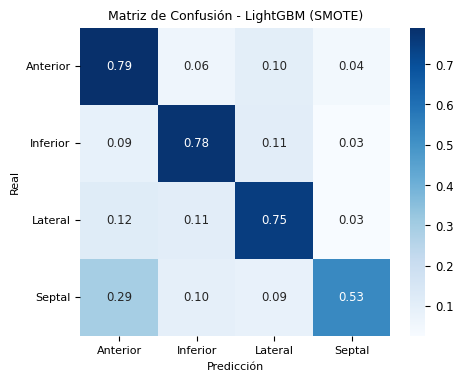

In [66]:
# Promedio métricas de validación
rows = []
for cls in clases_relevantes:
    p_mean, p_std = np.mean(metrics_per_class[cls]["precision"]), np.std(metrics_per_class[cls]["precision"])
    r_mean, r_std = np.mean(metrics_per_class[cls]["recall"]), np.std(metrics_per_class[cls]["recall"])
    f_mean, f_std = np.mean(metrics_per_class[cls]["f1"]), np.std(metrics_per_class[cls]["f1"])

    rows.append([
        cls,
        f"{p_mean:.2f} ± {p_std:.3f}",
        f"{r_mean:.2f} ± {r_std:.3f}",
        f"{f_mean:.2f} ± {f_std:.3f}"
    ])

# Crear DataFrame sin support
results_df = pd.DataFrame(rows, columns=["Clase", "Precision", "Recall", "F1-score"])
print("Promedio métricas de validación")
display(results_df)
# Accuracy global
print("Accuracy global: {:.2f} ± {:.3f}".format(np.mean(accuracies), np.std(accuracies)))


# Matriz de confusión promedio
cm_avg = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(5,4))
ax = sns.heatmap(cm_avg, annot=True, fmt='.2f', xticklabels=clases_relevantes,
                 yticklabels=clases_relevantes, cmap='Blues',
                 annot_kws={"size":8.5})

plt.xlabel("Predicción", fontsize=8)
plt.ylabel("Real", fontsize=8)
plt.title("Matriz de Confusión - LightGBM (SMOTE)", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8.5)
plt.show()